# Driver Behavior Modelling

From the provided dataset, select at least 2 of the 5 driving maneuvers and determine the sequence of events (atomic actions) that are characteristic of each maneuver. It is essential to analyze and compare the results in a complete and realistic manner. Keep in mind that all files (users) corresponding to the same maneuver should be considered to ensure the events are as representative as possible.

**Error**: Typo in filename `Driver5/STISIMData_3step-Turning` should be `Driver5/STISIMData_3step-Turnings`

---

## Import libraries

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Load Sample Dataset

In [3]:
data_path = 'data/'
drivers = list(os.listdir(data_path))
print("Drivers: " ,drivers)

maneuver_types = [f.split("_")[1].split(".")[0] for f in os.listdir(os.path.join(data_path, drivers[0]))]
print("Maneuvers set: ", maneuver_types)

Drivers:  ['Driver1', 'Driver2', 'Driver3', 'Driver4', 'Driver5']
Maneuvers set:  ['3step-Turnings', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings']


## Load Data of Every Driver
5 drivers available, 4 used and 1 completely isolated for testing purposes

1. Preprocess and create windows for each driver separately
2. Concatenate all drivers data into one dataframe

In [4]:
# Get all drivers data
dfs = {}
for driver in drivers:
    maneuvers = {}
    for maneuver in maneuver_types:
        df_path = os.path.join(data_path, driver, f"STISIMData_{maneuver}.xlsx")
        df = pd.read_excel(df_path)
        maneuvers[maneuver] = df
    dfs[driver] = maneuvers

print(dfs.keys())
print(dfs[drivers[0]].keys())

dict_keys(['Driver1', 'Driver2', 'Driver3', 'Driver4', 'Driver5'])
dict_keys(['3step-Turnings', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'])


In [5]:
print(dfs[drivers[0]][maneuver_types[0]].shape)
print(dfs[drivers[0]][maneuver_types[0]].dtypes)
dfs[drivers[0]][maneuver_types[0]].head()

(8662, 23)
Elapsed time            float64
Long Dist               float64
Lat Pos                 float64
Steering wheel angle    float64
Throttle input          float64
Brake pedal force       float64
Gas pedal                 int64
Brake pedal               int64
Clutch pedal              int64
Left turn                 int64
Right turn                int64
Gear                      int64
speed                   float64
RPM                     float64
Hand wheel torque       float64
Maneuver marker flag      int64
Accidents               float64
Collisions              float64
Peds Hit                float64
Speeding Tics           float64
Red Lgt Tics            float64
Speed Exceed            float64
Stop Sign Ticks         float64
dtype: object


,Elapsed time,Long Dist,Lat Pos,Steering wheel angle,Throttle input,Brake pedal force,Gas pedal,Brake pedal,Clutch pedal,Left turn,...,RPM,Hand wheel torque,Maneuver marker flag,Accidents,Collisions,Peds Hit,Speeding Tics,Red Lgt Tics,Speed Exceed,Stop Sign Ticks
0,0.104,0.01,2.17,-3.08,0.0,1.36,0,0,59453,0,...,184.118,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.157,0.01,2.17,-2.06,0.0,1.36,0,0,64253,0,...,219.193,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.210,0.01,2.17,-3.08,0.0,1.36,0,0,64253,0,...,259.028,-0.5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.267,0.01,2.17,-3.08,0.0,1.36,0,0,64253,0,...,290.445,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.318,0.01,2.17,-3.08,0.0,1.36,0,0,64253,0,...,326.126,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
import copy
# Deep copy of the dataframes

def get_dfs_copy(dfs):
    return copy.deepcopy(dfs)

dfs_copy = copy.deepcopy(dfs)
print(dfs_copy.keys())
print(dfs_copy["Driver1"].keys())

dict_keys(['Driver1', 'Driver2', 'Driver3', 'Driver4', 'Driver5'])
dict_keys(['3step-Turnings', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'])


### Preprocessing

#### Feature Selection

In [84]:
# Allowed attributes
attributes = ['speed', 'RPM', 'Steering wheel angle', 'Gas pedal', 'Brake pedal', 'Clutch pedal', 'Gear', 'Maneuver marker flag']
features = ['speed', 'RPM', 'Steering wheel angle', 'Gas pedal', 'Brake pedal', 'Clutch pedal', 'Gear']
target = 'Maneuver marker flag'

# Drop unnecessary columns
for driver in drivers:
    for maneuver in maneuver_types:
        dfs_copy[driver][maneuver] = dfs_copy[driver][maneuver][attributes]

dfs_copy[drivers[0]][maneuver_types[0]].head()

,speed,RPM,Steering wheel angle,Gas pedal,Brake pedal,Clutch pedal,Gear,Maneuver marker flag
0,0.04,184.118,-3.08,0,0,59453,0,0
1,0.02,219.193,-2.06,0,0,64253,0,0
2,0.00,259.028,-3.08,0,0,64253,0,0
3,0.00,290.445,-3.08,0,0,64253,0,0
4,0.00,326.126,-3.08,0,0,64253,0,0


### Gear discretization

¿Nos quedamos con la resta o con 1, 0 o -1?

Al quedarse con la resta mantienes la información del número de marchas que se suben o bajan.  
Por ejemplo: Driver1 va en 4ª y pone punto muerto directamente y luego pasa a 1ª. Porque al estar parando no baja de marchas 1 a 1.

In [85]:
def gear_discretization(df):
    # Previous gear
    df['Gear_t-1'] = df['Gear'].shift(1)
    # Drop NaN values
    df.dropna(inplace=True)
    # Gear difference
    df['Gear'] = df['Gear'] - df['Gear_t-1']
    # Gear increment
    df['Gear'] = df['Gear'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    # Remove previous gear column
    df.drop(columns=['Gear_t-1'], inplace=True)
    return df

def feature_discretization(df):
    for feature in features:
        # Previous gear
        df[f'{feature}_t-1'] = df[feature].shift(1)
    # Drop NaN values
    df.dropna(inplace=True)
    for feature in features:
        # Gear difference
        df[feature] = df[feature] - df[f'{feature}_t-1']
        # Gear increment
        df[feature] = df[feature].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
        # Remove previous gear column
        df.drop(columns=[f'{feature}_t-1'], inplace=True)
    return df

¿Ponemos ejemplo para que se entienda lo que estamos haciendo?

In [86]:
for driver in drivers:
    for maneuver in maneuver_types:
        print(f"Driver: {driver}, Maneuver: {maneuver}")
        # Remove missing values
        dfs_copy[driver][maneuver].dropna(inplace=True)
        print(dfs_copy[driver][maneuver].shape)
        # Gear discretization
        dfs_copy[driver][maneuver] = gear_discretization(dfs_copy[driver][maneuver])
        # Feature discretization
        # dfs_copy[driver][maneuver] = feature_discretization(dfs_copy[driver][maneuver])
        print(dfs_copy[driver][maneuver].shape)

Driver: Driver1, Maneuver: 3step-Turnings
(8662, 8)
(8661, 8)
Driver: Driver1, Maneuver: Overtaking
(6183, 8)
(6182, 8)
Driver: Driver1, Maneuver: Stopping
(11551, 8)
(11550, 8)
Driver: Driver1, Maneuver: Turnings
(11281, 8)
(11280, 8)
Driver: Driver1, Maneuver: U-Turnings
(5984, 8)
(5983, 8)
Driver: Driver2, Maneuver: 3step-Turnings
(9191, 8)
(9190, 8)
Driver: Driver2, Maneuver: Overtaking
(6263, 8)
(6262, 8)
Driver: Driver2, Maneuver: Stopping
(11515, 8)
(11514, 8)
Driver: Driver2, Maneuver: Turnings
(6315, 8)
(6314, 8)
Driver: Driver2, Maneuver: U-Turnings
(5206, 8)
(5205, 8)
Driver: Driver3, Maneuver: 3step-Turnings
(8965, 8)
(8964, 8)
Driver: Driver3, Maneuver: Overtaking
(7137, 8)
(7136, 8)
Driver: Driver3, Maneuver: Stopping
(12561, 8)
(12560, 8)
Driver: Driver3, Maneuver: Turnings
(15139, 8)
(15138, 8)
Driver: Driver3, Maneuver: U-Turnings
(7087, 8)
(7086, 8)
Driver: Driver4, Maneuver: 3step-Turnings
(11976, 8)
(11975, 8)
Driver: Driver4, Maneuver: Overtaking
(6022, 8)
(6021, 8

In [87]:
def create_windows(df, window_size, overlap=False):
    """If overlap take the present time row maneuver marker flag
    else take the majority vote of the window.
    """
    df = df.copy()
    new_data = {}

    for attr in attributes:
        for lag in range(window_size):
            new_data[f'{attr}_t-{lag}'] = df[attr].shift(lag)

    if overlap:
        new_data['Maneuver marker flag'] = new_data['Maneuver marker flag_t-0']
    else:
        new_data['Maneuver marker flag'] = (pd.DataFrame.from_dict(new_data)[[f'Maneuver marker flag_t-{i}' for i in range(window_size)]].sum(axis=1) >= window_size/2).astype(int)

    lagged_df = pd.DataFrame(new_data)
    lagged_df = lagged_df.dropna()
    lagged_df.drop(columns=[f'Maneuver marker flag_t-{i}' for i in range(window_size)], inplace=True)

    if not overlap:
        # Select non-overlapping rows
        lagged_df = lagged_df.iloc[::window_size]

    return lagged_df.reset_index(drop=True)

#### Windowing

In [88]:
# Create windows for first maneuver of the first driver
window_size = 20
overlap = True

# Example of windowed data
dfs_windowed = create_windows(dfs_copy[drivers[0]][maneuver_types[0]], window_size, overlap=overlap)
print(dfs_windowed.shape)
dfs_windowed.head()

(8642, 141)


,speed_t-0,speed_t-1,speed_t-2,speed_t-3,speed_t-4,speed_t-5,speed_t-6,speed_t-7,speed_t-8,speed_t-9,...,Gear_t-11,Gear_t-12,Gear_t-13,Gear_t-14,Gear_t-15,Gear_t-16,Gear_t-17,Gear_t-18,Gear_t-19,Maneuver marker flag
0,0.14,0.09,0.08,0.00,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.24,0.14,0.09,0.08,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.36,0.24,0.14,0.09,0.08,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,0.51,0.36,0.24,0.14,0.09,0.08,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.69,0.51,0.36,0.24,0.14,0.09,0.08,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [89]:
for driver in drivers:
    for maneuver in maneuver_types:
        dfs_copy[driver][maneuver] = create_windows(dfs_copy[driver][maneuver], window_size, overlap=overlap)
        # dfs_copy[driver][maneuver] = pd.get_dummies(dfs_copy[driver][maneuver], columns=[f"Gear_t-{i}" for i in range(window_size)], drop_first=True)

dfs_processed = copy.deepcopy(dfs_copy)
print(dfs_processed.keys(), dfs_processed["Driver1"].keys())

dict_keys(['Driver1', 'Driver2', 'Driver3', 'Driver4', 'Driver5']) dict_keys(['3step-Turnings', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'])


In [90]:
dfs_processed["Driver1"]["Stopping"].shape

(11531, 141)

In [91]:
dfs_copy[drivers[0]][maneuver_types[0]].head().T

,0,1,2,3,4
speed_t-0,0.14,0.24,0.36,0.51,0.69
speed_t-1,0.09,0.14,0.24,0.36,0.51
speed_t-2,0.08,0.09,0.14,0.24,0.36
speed_t-3,0.00,0.08,0.09,0.14,0.24
speed_t-4,0.00,0.00,0.08,0.09,0.14
...,...,...,...,...,...
Gear_t-16,0.00,0.00,0.00,0.00,1.00
Gear_t-17,0.00,0.00,0.00,0.00,0.00
Gear_t-18,0.00,0.00,0.00,0.00,0.00
Gear_t-19,0.00,0.00,0.00,0.00,0.00


---

## Data preprocessing
### Merger Drivers

In [92]:
maneuver_name = "Stopping"

dfs_drivers = []
for  driver in drivers:
    dfs_drivers.append(dfs_processed[driver][maneuver])

driver_5_size = dfs_processed["Driver5"][maneuver_name].shape[0]
dfs_merged = pd.concat(dfs_drivers)
dfs_merged.fillna(False, inplace=True)

dfs_train = dfs_merged.iloc[:-driver_5_size]
dfs_test = dfs_merged.iloc[-driver_5_size:]
print(f"Train drivers: {dfs_train.shape}", f" Test driver: [{dfs_test.shape}]")
dfs_merged.head()

Train drivers: (18846, 141)  Test driver: [(11569, 141)]


,speed_t-0,speed_t-1,speed_t-2,speed_t-3,speed_t-4,speed_t-5,speed_t-6,speed_t-7,speed_t-8,speed_t-9,...,Gear_t-11,Gear_t-12,Gear_t-13,Gear_t-14,Gear_t-15,Gear_t-16,Gear_t-17,Gear_t-18,Gear_t-19,Maneuver marker flag
0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.03,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.11,0.03,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.26,0.11,0.03,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.43,0.26,0.11,0.03,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [93]:
features_lagged = [f for f in dfs_merged if f != "Maneuver marker flag"]
X_train = dfs_train[features_lagged]
y_train = dfs_train["Maneuver marker flag"]

X_test = dfs_test[features_lagged]
y_test = dfs_test["Maneuver marker flag"]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18846, 140), (11569, 140), (18846,), (11569,))

In [94]:
# Normalización de las variables numéricas
numerical_features = X_train.select_dtypes(include=['number']).columns
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

/tmp/ipykernel_1162/1635126295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
/tmp/ipykernel_1162/1635126295.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


### Decission Tree

In [95]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

seed = 42

# Espacio de búsqueda de los hiperparámetros para árboles de regresión
param_grid = {'max_depth': list(range(2,10,2)),
              'min_samples_split': list(range(2,8,2)),
              'min_samples_leaf': list(range(22,30,2))}

# Tamaño de la parte de validación
size=int(len(X_train)*2/10)

# Dividimos en parte de entrenamiento y parte de validación, utilizando TimeSeriesSplit
folds = TimeSeriesSplit(n_splits=3, test_size=size)

# Mostrar los índices de entrenamiento y validación
for train_index, val_index in folds.split(X_train):
    print("TRAIN:", train_index, "VAL:", val_index)

# Ajuste de hiperparámetros con GridSearch
regr = GridSearchCV(DecisionTreeClassifier(random_state=seed),
                param_grid, 
                cv=folds,
                scoring='f1',
                n_jobs=-1, verbose=1)

# Entrenamos el modelo con todos los datos de entrenamiento
np.random.seed(seed)
regr.fit(X=X_train, y=y_train)

# Mejores hiperparámetros encontrados
print(regr.best_params_)
print(regr.best_score_)

# Predicción
y_pred = regr.predict(X_test)

# Métricas
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))

print(classification_report(y_true=y_test, y_pred=y_pred, target_names=["None", maneuver_name]))

# Matriz de confusión
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)

TRAIN: [   0    1    2 ... 7536 7537 7538] VAL: [ 7539  7540  7541 ... 11305 11306 11307]
TRAIN: [    0     1     2 ... 11305 11306 11307] VAL: [11308 11309 11310 ... 15074 15075 15076]
TRAIN: [    0     1     2 ... 15074 15075 15076] VAL: [15077 15078 15079 ... 18843 18844 18845]


Fitting 3 folds for each of 48 candidates, totalling 144 fits
{'max_depth': 6, 'min_samples_leaf': 26, 'min_samples_split': 2}
0.7159733389282247
Accuracy: 0.8559080300803873
Precision: 0.8511151295961422
Recall: 0.8206121658271988
F1: 0.8355853634480718
              precision    recall  f1-score   support

        None       0.86      0.88      0.87      6407
    Stopping       0.85      0.82      0.84      5162

    accuracy                           0.86     11569
   macro avg       0.86      0.85      0.85     11569
weighted avg       0.86      0.86      0.86     11569

[[5666  741]
 [ 926 4236]]


In [96]:
print(y_pred)

[1 1 1 ... 0 0 0]


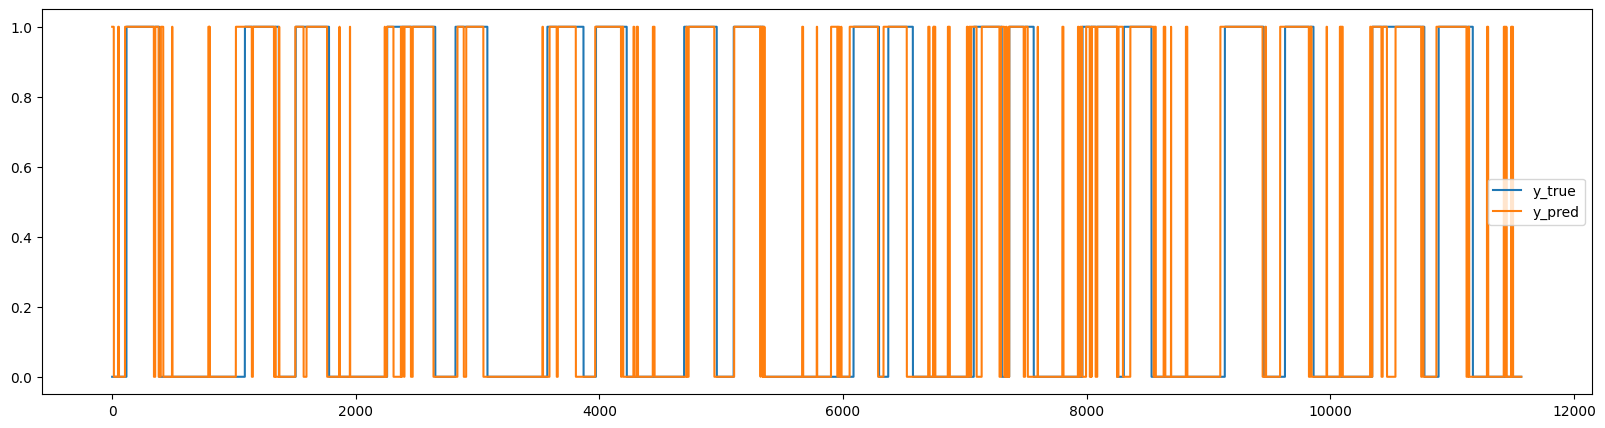

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(y_test.values, label="y_true")
plt.plot(y_pred, label="y_pred")
plt.legend()
plt.show()

In [98]:
# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions to binary values using a threshold
threshold = 0.5
y_pred_binary = np.where(y_pred >= threshold, 1, 0)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
confusion = confusion_matrix(y_test, y_pred_binary)
print(classification_report(y_true=y_test, y_pred=y_pred_binary, target_names=["None", "Stopping"]))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Confusion Matrix:\n{confusion}")

              precision    recall  f1-score   support

        None       0.88      0.94      0.91      6407
    Stopping       0.91      0.84      0.87      5162

    accuracy                           0.89     11569
   macro avg       0.90      0.89      0.89     11569
weighted avg       0.89      0.89      0.89     11569

Accuracy: 0.8915204425620192
Precision: 0.9143160127253447
Recall: 0.8351414180550174
F1-Score: 0.872937126657892
Confusion Matrix:
[[6003  404]
 [ 851 4311]]


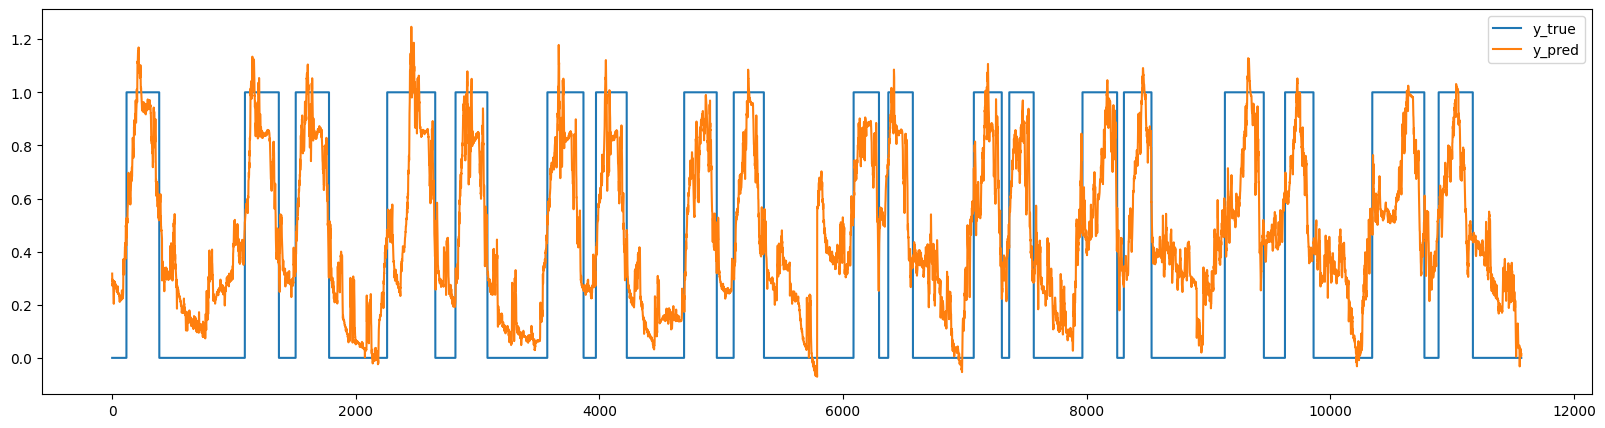

In [99]:
plt.figure(figsize=(20,5))
plt.plot(y_test.values, label="y_true")
plt.plot(y_pred, label="y_pred")
plt.legend()
plt.show()

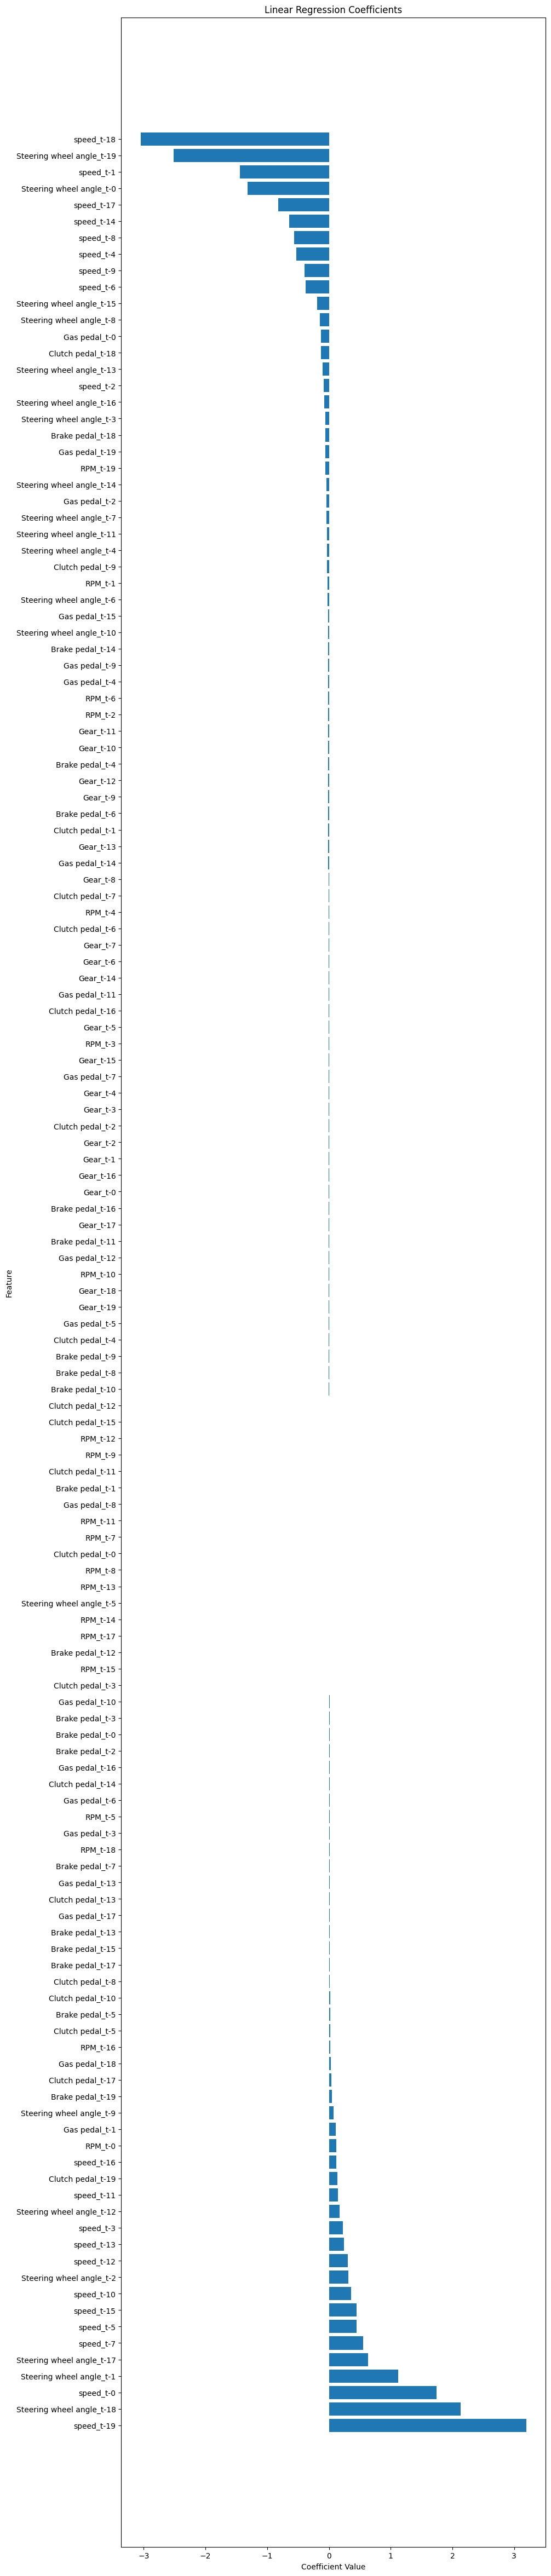

In [100]:
coefficients = model.coef_
feature_names = X_train.columns  # Get feature names

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values('Coefficient', ascending=False) # Sort by impact

plt.figure(figsize=(10, 60))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Linear Regression Coefficients')
plt.show()

In [101]:
# import shap

# explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 10)) #Sample needed
# shap_values = explainer.shap_values(X_test) #X_test

# shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns) #X_test

# instance_index = 0 # Choose an instance to explain (e.g., the first one)
# shap.force_plot(explainer.expected_value, shap_values[instance_index,:], features=X_test.iloc[instance_index,:], feature_names = X_test.columns)

# for feature in X_test.columns:
#     shap.dependence_plot(feature, shap_values, features=X_test, feature_names = X_test.columns)